### Imports

In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl


In [2]:
from sklearn.datasets import fetch_openml

# Download the MNIST dataset 
mnist = fetch_openml('mnist_784', as_frame=False)

/Users/yyh/Documents/handson-ML3/venv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


6


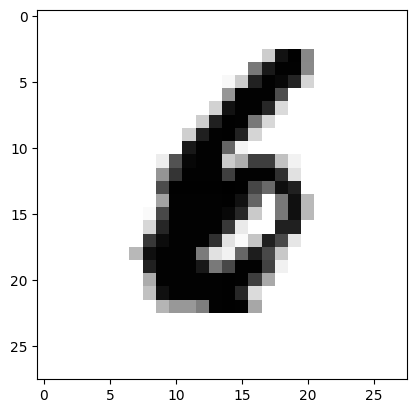

In [4]:
# Lets visualize a digit from our dataset
def show_image(img: np.array, dim: int = 28) -> None:
    """
    Takes a array of pixels, then plots a visual representation of that image
    
    Args:
        img: list: an array that represents the pixel values of an image
        dim: int: the dimension of the image
    """
    
    visual = img.reshape(dim, dim)
    plt.imshow(visual, cmap='binary')
    plt.show()


random_img = X[129]
print(y[129])
show_image(random_img)


Before we continue it is important that we set aside a test set


_The data is already shuffled. Therefore, we can simply split the data at any index_

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before anything, lets experiment with only the digit 5

In [6]:
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

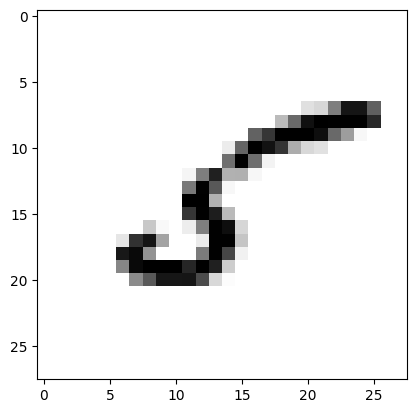

array([ True])

In [8]:
show_image(X[11])

sgd_clf.predict([X[11]])

You've got a running model. But, does it perform well? This is the tricky part. Lets first apply cross validation to see how our performance holds over different folds.


In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Be wary of the accuracy metric. As the example above shows, if the model classifies every data point in the training sample as non-5 (Dummy Classifier) then it achieves a accuracy score of 90%. Suddenly, our SGD Classifier is only an improvement of 6%.

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

conf_matrix = confusion_matrix(y_train_5, y_train_pred)

print(f'Confusion Matrix: \n{conf_matrix}')
print(f'Precision: {precision_score(y_train_5, y_train_pred)}')
print(f'Recall: {recall_score(y_train_5, y_train_pred)}')

Confusion Matrix: 
[[53892   687]
 [ 1891  3530]]
Precision: 0.8370879772350012
Recall: 0.6511713705958311


Let's see what different decision thresholds mean for our model

In [13]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [14]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


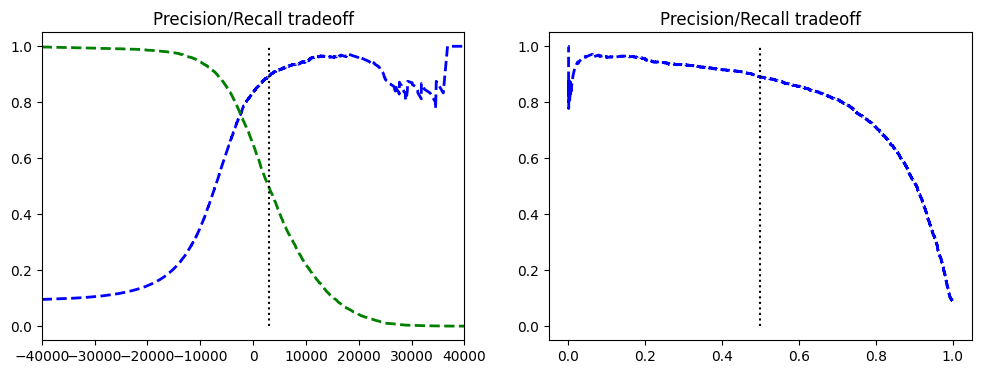

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Visual representation of the tradeoff
axes[0].plot(thresholds, precisions[:-1], 'b--', label = 'Precision', linewidth = 2)
axes[0].plot(thresholds, recalls[:-1], 'g--', label = 'Recall', linewidth = 2)
axes[0].vlines(3000, 0, 1.0, 'k', 'dotted', label='Threshold')
axes[0].set_xlim(-40000, 40000)
axes[0].set_title('Precision/Recall tradeoff')

# The precision recall curve
axes[1].plot(recalls, precisions, 'b--', label = 'Precision/Recall curve', linewidth = 2)
axes[1].vlines(.5, 0, 1.0, 'k', 'dotted', label='Threshold')
axes[1].set_title('Precision/Recall tradeoff')


plt.show()

In [16]:
# select the threshold to reach a precision of 90%
idx_90_precision = np.argmax(precisions >= .9)

threshold_90_precision = thresholds[idx_90_precision]

next we continue with a strong 

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

ROC (Area under the curve): 0.9604938554008616


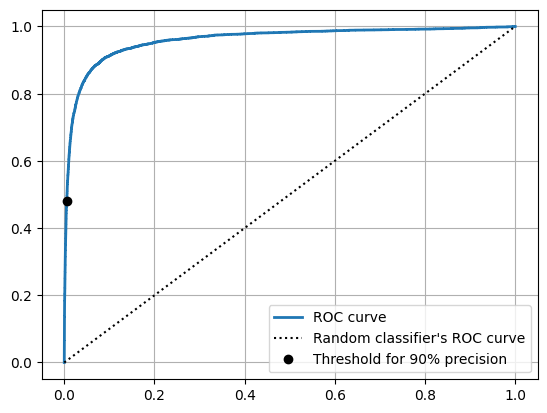

In [18]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

print(f'ROC (Area under the curve): {roc_auc_score(y_train_5, y_scores)}')

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.legend()
plt.grid()
plt.show()

Now let's compare what happened if we use a different model. Such as the RandomForrestClassifier


In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [20]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forrest = precision_recall_curve(y_train_5, y_scores_forest)

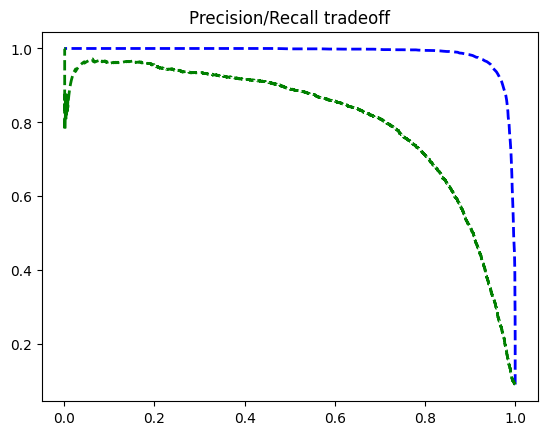

In [21]:
# The precision recall curve
plt.plot(recalls_forest, precisions_forest, 'b--', label = 'RandomForrestClassifier', linewidth = 2)
plt.plot(recalls, precisions, 'g--', label = 'SGDClassifier', linewidth = 2)
plt.title('Precision/Recall tradeoff')

plt.show()

In [22]:
from sklearn.metrics import f1_score

y_train_pred_forest = y_probas_forest[:, 1] >= .5


print('Scores:')
print(f'f1_score: {f1_score(y_train_5, y_train_pred_forest)}')
print(f'roc_auc_score: {roc_auc_score(y_train_5, y_train_pred_forest)}')


Scores:
f1_score: 0.9274509803921569
roc_auc_score: 0.9358174809192218


In [25]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42)
svc_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)